In [1]:
import numpy as np
def Kuramoto(Theta,t,omega,N,K,mk,Aij):
    # print("Case m = 0")
    theta = 1*Theta
    theta_i,theta_j = np.meshgrid(theta,theta,sparse=True)
    dtheta = omega + K/mk*np.sum(Aij*np.sin(theta_j - theta_i),axis=0) 
    Theta[:N] = dtheta
    return Theta

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from numba import jit

In [3]:
from scipy.special import erfinv
import scipy.stats as scs

def _make_init_theta_(seed,N):
    if type(seed)==str:
        init_theta= np.linspace(-np.pi,np.pi,N,endpoint=False)
    else:
        np.random.seed(seed)
        init_theta = np.random.uniform(-np.pi, np.pi, size=N)
    return init_theta
def Q_Normal(N, mean=0, sigma=1,seed=None):
    """return theta, omega, Kc"""
    init_theta = _make_init_theta_(seed,N)
    init_omega = np.array([mean +sigma*(2**0.5)*erfinv((2*i - N - 1)/(N+1)) for i in range(1,N+1)])
    Kc = 2 / (np.pi * scs.cauchy.pdf(mean, mean, sigma))
    return init_theta, init_omega, Kc

In [4]:
# @cuda.jit(nopython = True,chache=True)
@jit(nopython = True)
def RKHG(f,y0,t,D,args=()):
    n = len(t)
    size = len(y0)
    y = np.zeros((n, size))
    y[0] = y0
    h = t[1] - t[0]
    sh = np.sqrt(h)
    for i in range(n - 1):
        S = np.random.choice(np.array([-1,1]),size=size)
        dW = np.random.normal(0,1,size)*sh
        k1 = h*f(y[i],t[i],*args) + (dW - S*sh)*D
        k2 = h*f(y[i]+k1,t[i]+h,*args) + (dW + S*sh)*D
        y[i+1] = y[i] + 0.5*(k1+k2)
    return y


@jit(nopython = True,cache=True)
def RK4(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0

    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1 = f(y[i], t[i], *args)
        k2 = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3 = f(y[i] + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4 = f(y[i] + k3 * h, t[i] + h, *args)
        y[i + 1] = y[i] + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return y



# @cuda.jit#(nopython = True,chache=True)
@jit(nopython = True,cache=True)
def Kuramoto_SOL_CHIMERA(Theta,t,omega,N,Kij,alpha):
    # print("Case m = 0")
    Theta = Theta.copy()
    theta = Theta[:N]

    theta_i= theta.reshape(1,-1)
    theta_j = theta_i.T
    # theta_i,theta_j = np.meshgrid(theta,theta,sparse=True)
    dtheta = omega +  np.sum(Kij*np.sin(theta_j - theta_i - alpha),axis=0)
    Theta[:N] = dtheta
    return Theta

In [5]:
N1 = 128
N2 = 128
theta_init = np.random.uniform(0,np.pi,(N1+N2))

In [6]:
N1 = 128
N2 = 128
theta_init = np.random.uniform(0,np.pi,(N1+N2)).astype(np.float32)
theta_init[:N1] = np.random.uniform(0,2*np.pi,(N1)).astype(np.float32)
theta_init[N1:] = np.random.uniform(0,2*np.pi,(N2)).astype(np.float32)
np.abs(np.mean(np.exp(theta_init*1j),axis=0))


0.09939021

In [7]:
2 - 3**0.5

0.2679491924311228

A = 0.31, $\beta$ = 0.10
1
2
3
4
5
6
7
8
9
10
11
12
0.6977778177531977


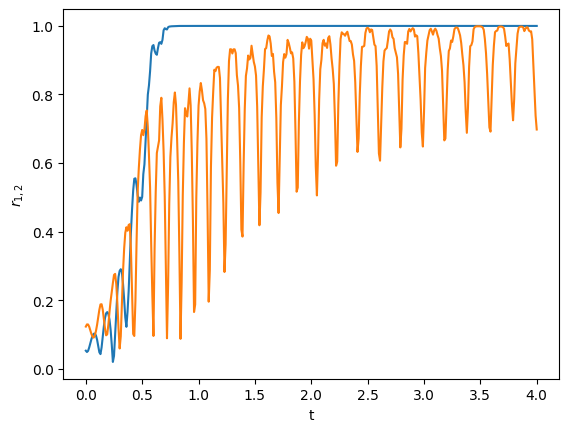

In [73]:
N1 = 128 + 50
N2 = 128 
theta_init = np.random.uniform(0,2*np.pi,(N1+N2))
theta_init[:N1] = np.ones_like(np.random.uniform(0,2*np.pi,(N1)))
theta_init[N1:] = np.random.uniform(0,2*np.pi,(N2))


A = 0.31
beta = 0.1
nu = (1-A)/2
mu = (1+A)/2

K_ij = nu*np.ones((N1+N2,N1+N2))
K_ij[:N1,:N1] = mu
K_ij[N1:,N1:] = mu



t_end = 4
dt = 0.01
r_last1 = 1
r_last2 = 1

print(rf'A = {A:.02f}, $\beta$ = {beta:.02f}')

num =0 
while min(r_last1,r_last2)>0.9:
    num +=1
    theta_init = np.random.uniform(-np.pi,np.pi,(N1+N2))
    # theta_init[:N1] = np.ones_like(np.random.uniform(-np.pi,np.pi,(N1)))
    theta_init[:N1] = np.random.uniform(-np.pi,np.pi,(N1))
    theta_init[N1:] = np.random.uniform(-np.pi,np.pi,(N2))
    
    t = np.arange(0, t_end+dt/2, dt)
    omega = 0
    alpha = np.pi/2 - beta

    sol = RK4(Kuramoto_SOL_CHIMERA,theta_init,t, args=(omega, N1+N2, K_ij,alpha))

    rabs1 = np.mean(np.exp(sol.T[:N1]*1j),axis=0)
    rabs2 = np.mean(np.exp(sol.T[N1:]*1j),axis=0)
    np.abs(np.mean(np.exp(theta_init[:N1]*1j),axis=0))
    r_I_1,psi_I_1 = abs(rabs1),np.angle(rabs1[0])
    r_I_2,psi_I_2 = abs(rabs2),np.angle(rabs2[0])
    # plt.axhline(r_I_1)
    # plt.axhline(r_I_2)
    r_last1 = r_I_1[-1]
    r_last2 = r_I_2[-1]
    print(num)
    
plt.figure()
plt.plot(t,r_I_1)
plt.plot(t,r_I_2)
plt.xlabel('t')
plt.ylabel(r'$r_{1,2}$')

print(min(r_last1,r_last2))


In [67]:
t_end = 50
dt = 0.01
t = np.arange(0, t_end+dt/2, dt)

sol = RK4(Kuramoto_SOL_CHIMERA,theta_init,t, args=(omega, N1+N2, K_ij,alpha))

In [68]:
rabs1 = np.mean(np.exp(sol.T[:N1]*1j),axis=0)
rabs2 = np.mean(np.exp(sol.T[N1:]*1j),axis=0)
np.abs(np.mean(np.exp(theta_init[:N1]*1j),axis=0))
r_I_1,psi_I_1 = abs(rabs1),np.angle(rabs1[0])
r_I_2,psi_I_2 = abs(rabs2),np.angle(rabs2[0])

0.8666439363866492


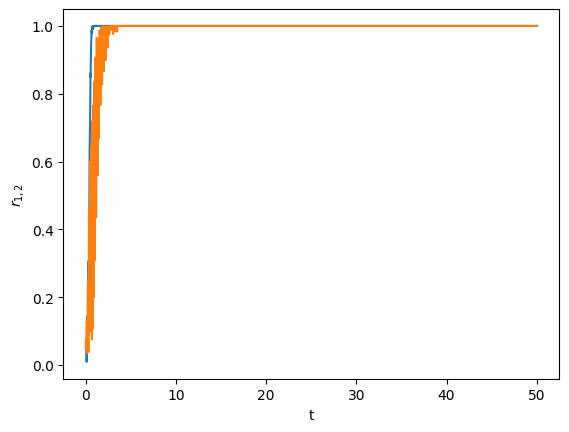

In [69]:
plt.figure()
plt.plot(t,r_I_1)
plt.plot(t,r_I_2)
plt.xlabel('t')
plt.ylabel(r'$r_{1,2}$')

print(min(r_last1,r_last2))


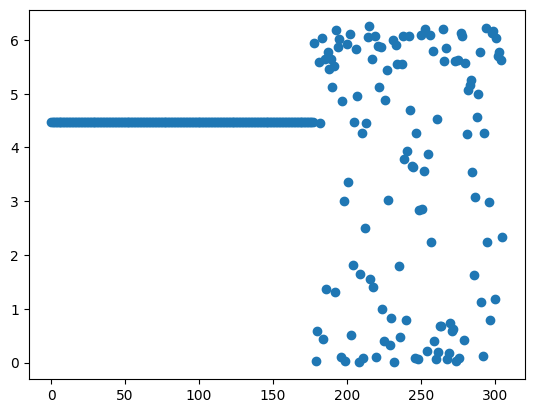

In [63]:
# plt.scatter(np.arange(N1+N2),sol[-1]%(np.pi*2))
plt.scatter(np.arange(N1+N2),sol[-100]%(np.pi*2))


(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,
         1.,  2.,  2., 16., 84., 13.,  4.,  1.,  0.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.]),
 array([0.        , 0.21666156, 0.43332312, 0.64998469, 0.86664625,
        1.08330781, 1.29996937, 1.51663094, 1.7332925 , 1.94995406,
        2.16661562, 2.38327719, 2.59993875, 2.81660031, 3.03326187,
        3.24992343, 3.466585  , 3.68324656, 3.89990812, 4.11656968,
        4.33323125, 4.54989281, 4.76655437, 4.98321593, 5.1998775 ,
        5.41653906, 5.63320062, 5.84986218, 6.06652374, 6.28318531]),
 <BarContainer object of 29 artists>)

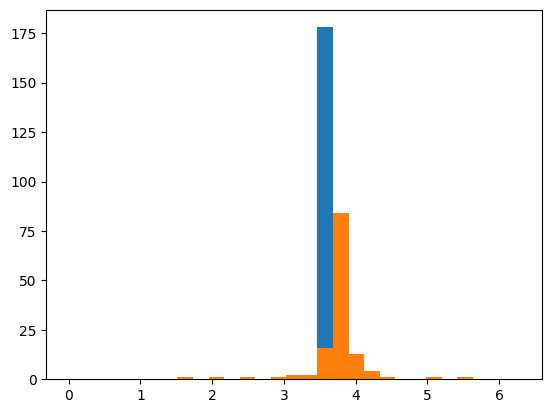

In [65]:
bins = np.linspace(0,2*np.pi,30)
plt.hist((sol[-1]%(np.pi*2))[:N1],bins=bins)
plt.hist((sol[-1]%(np.pi*2))[N1:],bins=bins)
# plt.hist((sol[-1][N1:]),bins=50)#%(np.pi*2))[N1:],bins=bins)
# plt.hist(sol[-1][N1:])

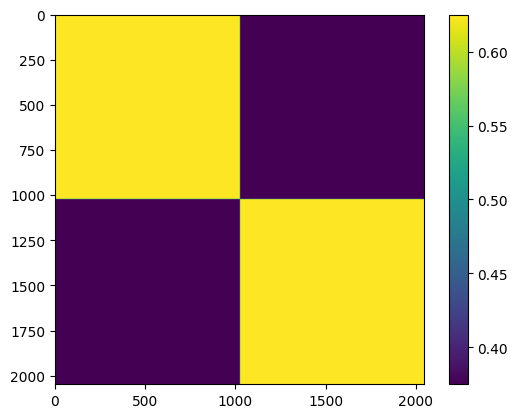

In [713]:
plt.imshow(K_ij)
plt.colorbar()


In [39]:
# # @jit(nopython=True)
# def get_order_parameter(theta,N):
#     ''' get theta and return r and theta'''
#     rpsi = 1/N*np.sum(np.exp(1j*theta))
#     r = np.abs(rpsi)
#     psi = np.angle(rpsi)
#     return r,psi

# # @jit(nopython=True)
# def Kuramoto_mf(Theta,t,omega,N,K):
#     # print("Case m = 0")
#     Theta = Theta.copy()
#     theta = Theta[:N]
#     r,psi = get_order_parameter(theta,N)
#     dtheta = omega + K*r*np.sin(psi - theta)
#     Theta[:N] = dtheta
#     return Theta


# def Kuramoto(Theta,t,omega,N,K,mk,Aij):
#     # print("Case m = 0")
#     Theta = Theta.copy()
#     theta = Theta[:N]
#     theta_i,theta_j = np.meshgrid(theta,theta,sparse=True)
#     dtheta = omega + K/mk*np.sum(Aij*np.sin(theta_j - theta_i),axis=0) 
#     Theta[:N] = dtheta
#     return Theta

# # @jit(nopython=True)
# def Kuramoto_mf_AR(Theta,t,omega,N,K,b):
#     # print("Case m = 0")
#     Theta = Theta.copy()
#     theta = Theta[:N]
#     r,psi = get_order_parameter(theta,N)
#     dtheta = omega + K*r*np.sin(psi - theta) - b*np.sin(theta)
#     Theta[:N] = dtheta
#     return Theta


# def Kuramoto_AR(Theta,t,omega,N,K,mk,Aij,b):
#     # print("Case m = 0")
#     Theta = Theta.copy()
#     theta = Theta[:N]
#     theta_i,theta_j = np.meshgrid(theta,theta,sparse=True)
#     dtheta = omega +  K/mk*np.sum(Aij*np.sin(theta_j - theta_i),axis=0)  - b*np.sin(theta)
#     Theta[:N] = dtheta
#     return Theta

# def get_order_parameter_ann(theta,N,mk,DEGT):
#     ''' get theta and return r and theta'''
#     rpsi = 1/(N*mk)*np.sum(DEGT*np.exp(1j*theta))
#     r = np.abs(rpsi)
#     psi = np.angle(rpsi)
#     return r,psi



# def Kuramoto_AMF_AR(Theta,t,omega,N,K,mk,DEGT,b):
#     # print("Case m = 0")
#     Theta = Theta.copy()
#     theta = Theta[:N]
#     r,psi = get_order_parameter_ann(theta,N,mk,DEGT)
#     dtheta = omega + K/mk*r*DEGT.flatten()*np.sin(psi - theta) - b*np.sin(theta)
#     Theta[:N] = dtheta
#     return Theta


In [ ]:
mk = 5
N = 1000
p = mk/(N)
# G = nx.erdos_renyi_graph(N,p)
G = nx.barabasi_albert_graph(N,5)

In [ ]:
A = nx.adjacency_matrix(G)
Aij = A.todense()
Deg = Aij.sum(axis=1)
DegT = Deg.reshape(-1,1)
mk = Deg.mean()
mk

9.95

# 캡스톤

In [732]:
A1_xg = 1.7
A2_xg = 1.4
A2_Ag = 1.4

A1_prob = A1_xg/(A1_xg+A2_xg)
A2_prob = 1 - A1_prob


In [733]:
A1_xg -  A2_Ag

0.30000000000000004

In [737]:
A1_prob, A2_prob

(0.5483870967741936, 0.4516129032258064)

In [738]:
np.random.rand()

0.015843059113251345

# Fixed point analysis

C:\Users\kim9y\AppData\Local\Temp\ipykernel_50544\1313447418.py:18: RuntimeWarning: divide by zero encountered in divide
  dpsi = (1+r**2)/(2*r) * (mu*r*np.sin(alpha)-nu*np.sin(psi-alpha)) - mu*np.sin(alpha)-nu*r*np.sin(psi+alpha)
C:\Users\kim9y\AppData\Local\Temp\ipykernel_50544\1313447418.py:39: RuntimeWarning: invalid value encountered in divide
  V = V / np.sqrt(U**2 + V**2);
C:\Users\kim9y\AppData\Local\Temp\ipykernel_50544\1313447418.py:52: UserWarning: The following kwargs were not used by contour: 'pivot'
  plt.contourf(R,PSI,M,pivot='mid',cmap='jet',zorder=3,levels=[-0.01,0.01])
C:\Users\kim9y\AppData\Local\Temp\ipykernel_50544\1313447418.py:60: RuntimeWarning: invalid value encountered in divide
  V = V / np.sqrt(U**2 + V**2);


Text(0.5, 1.0, 'A=0.2,$\\beta$=0.1')

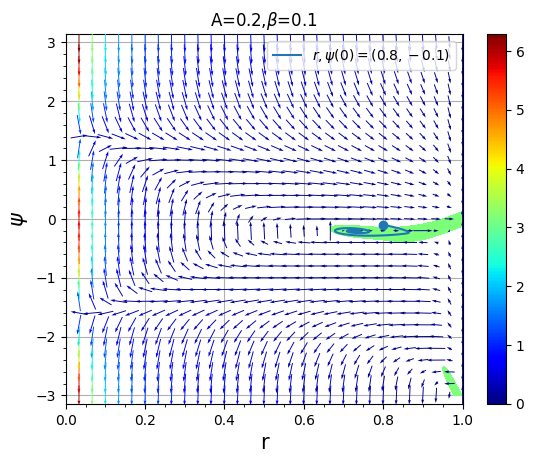

In [197]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint


A = 0.2
beta = 0.1
nu = (1-A)/2
mu = (1+A)/2


def myFun(u,t=0,A=0.1,beta=0.1):
	r,psi = u[0],u[1]
	nu = (1-A)/2
	mu = (1+A)/2
	alpha = np.pi/2 - beta
	dr = (1-r**2)/2 *(mu*r*np.cos(alpha)+nu*np.cos(psi-alpha))
	dpsi = (1+r**2)/(2*r) * (mu*r*np.sin(alpha)-nu*np.sin(psi-alpha)) - mu*np.sin(alpha)-nu*r*np.sin(psi+alpha)
	return (dr,dpsi)


A = 0.2
beta = 0.1

u0 = [0.1,-0.3]
t = np.linspace(0,3000,3000)
u0s = [[0.8,-0.1]]#,[-0.5,3],[-1,-1],[-2,-0.5]]
for u0 in u0s:
	u = odeint(myFun,u0,t,args=(A,beta))
	plt.plot(u[:,0],u[:,1],lw=1.5,label=r'$r,\psi(0)=(%.1f,%.1f)$'%(u0[0],u0[1]),zorder=5)
	plt.scatter(u[0,0],u[0,1],zorder=5)

x = np.linspace(0,1,501)
y = np.linspace(-3,3,501)
R,PSI = np.meshgrid(x,y)
U,V = myFun([R,PSI],A=A,beta=beta)
M = (np.hypot(U,V))
U = U / np.sqrt(U**2 + V**2);
V = V / np.sqrt(U**2 + V**2);
MIN = np.argmin(M)

xs = np.linspace(-3,-1e-5,1000)



# plt.figure(dpi=400)
# plt.axhline(0,color='black')
# plt.plot(xs,-np.log(-xs),color='black')
# plt.plot(x,xdot(x,y))
# Q = plt.quiver(R*np.cos(PSI),R*np.sin(PSI),U,V,M,pivot='mid',cmap='jet',zorder=3)
# Q = plt.quiver(R,PSI,U,V,M,pivot='mid',cmap='jet',zorder=3)
plt.contourf(R,PSI,M,pivot='mid',cmap='jet',zorder=3,levels=[-0.01,0.01])

x = np.linspace(0,1,31)
y = np.linspace(-3,3,31)
R,PSI = np.meshgrid(x,y)
U,V = myFun([R,PSI],A=A,beta=beta)
M = (np.hypot(U,V))
U = U / np.sqrt(U**2 + V**2);
V = V / np.sqrt(U**2 + V**2);
Q = plt.quiver(R,PSI,U,V,M,scale=20,pivot='mid',cmap='jet',zorder=3)



plt.colorbar()
plt.xlim(0,1)
plt.ylim(-np.pi,np.pi)
# plt.ylim(-0.5,0.5)
ax =plt.gca()
ax.grid(True)
ax.minorticks_on()
plt.plot(-1,0,'o',ms=10,markeredgewidth=2,markerfacecolor='white')
plt.xlabel('r',fontsize=15)
plt.ylabel(r'$\psi$',fontsize=15)
plt.legend()


psi = -2*beta -2*beta**2 - 7/3*beta**3 + 20*beta**4/3 + 181*beta**5/60
plt.title(rf'A={A},$\beta$={beta}')

# qk = plt.quiverkey(Q, 0.9, 0.9, 1, r'$2 \frac{m}{s}$', labelpos='E',
#                    coordinates='figure')

In [168]:
u[-1]

array([ 0.63240142, -0.20541937])

In [9]:
N1 = 128
N2 = 128 
theta_init = np.random.uniform(0,2*np.pi,(N1+N2))
theta_init[:N1] = np.zeros_like(np.random.uniform(0,2*np.pi,(N1)))
theta_init[N1:] = np.random.uniform(0,2*np.pi,(N2))


A = 0.25
beta = 0.1
nu = (1-A)/2
mu = (1+A)/2

K_ij = nu*np.ones((N1+N2,N1+N2))
K_ij[:N1,:N1] = mu
K_ij[N1:,N1:] = mu



t_end = 4
dt = 0.01
r_last1 = 1
r_last2 = 1

In [12]:
std = 0.1
theta_init[N1:] = np.random.normal(-0.1,std,(N2))
r_ = np.abs(np.mean(np.exp(theta_init[N1:]*1j)))
r_

0.9953108616935333

In [31]:
from scipy.stats import norm
from scipy.interpolate import interp1d


In [33]:
stds = np.linspace(1e-3,3,100)
rs = []
for std in stds:
    # theta_init[N1:] = scipy.normal(-0.1,std,(N2))
    x_ = np.linspace(0,1,1000)[1:-1]
    y_ = norm.ppf(x_,loc=-0.1,scale=std)
    # theta_init[N1:] = norm.pdf(x_,-0.1,std)
    r_ = np.abs(np.mean(np.exp(y_*1j)))
    rs.append(r_)
r_to_stds = interp1d(rs,stds)

Text(0.5, 0, 'std')

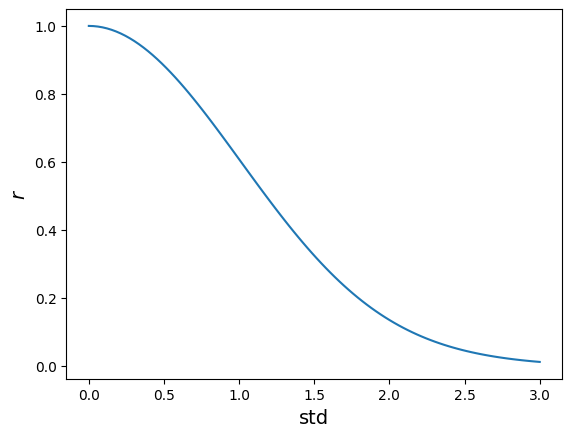

In [65]:
plt.plot(stds,rs)
plt.ylabel(r'$r$',fontsize=14)
plt.xlabel('std',fontsize=14)

In [207]:
r = 0.8
std_r = r_to_stds(r)

A = 0.20, $\beta$ = 0.10
1.0


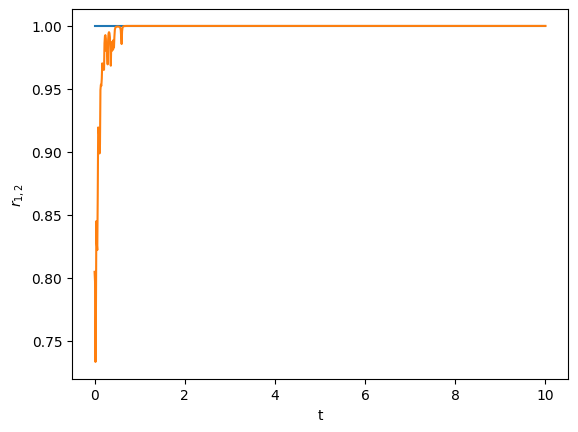

In [209]:
N1 = 128 
N2 = 128
theta_init = np.random.uniform(0,2*np.pi,(N1+N2))
theta_init[:N1] = np.zeros_like(np.random.uniform(0,2*np.pi,(N1)))
theta_init[N1:] = np.random.normal(-0.2,std_r,N2)
# (np.linspace(0,1,N2+2)[1:-1],-0.1,std_r)


A = 0.2
beta = 0.1
nu = (1-A)/2
mu = (1+A)/2

K_ij = nu*np.ones((N1+N2,N1+N2))
K_ij[:N1,:N1] = mu
K_ij[N1:,N1:] = mu



t_end = 10
dt = 0.01
r_last1 = 1
r_last2 = 1

print(rf'A = {A:.02f}, $\beta$ = {beta:.02f}')

num =0 
# while min(r_last1,r_last2)>0.9:
#     num +=1
    # theta_init = np.random.uniform(-np.pi,np.pi,(N1+N2))
    # theta_init[:N1] = np.ones_like(np.random.uniform(-np.pi,np.pi,(N1)))
    # theta_init[:N1] = np.random.uniform(-np.pi,np.pi,(N1))
    # theta_init[N1:] = np.random.uniform(-np.pi,np.pi,(N2))
    
t = np.arange(0, t_end+dt/2, dt)
omega = 0
alpha = np.pi/2 - beta

sol = RK4(Kuramoto_SOL_CHIMERA,theta_init,t, args=(omega, N1+N2, K_ij,alpha))

rabs1 = np.mean(np.exp(sol.T[:N1]*1j),axis=0)
rabs2 = np.mean(np.exp(sol.T[N1:]*1j),axis=0)
np.abs(np.mean(np.exp(theta_init[:N1]*1j),axis=0))
r_I_1,psi_I_1 = abs(rabs1),np.angle(rabs1[0])
r_I_2,psi_I_2 = abs(rabs2),np.angle(rabs2[0])
# plt.axhline(r_I_1)
# plt.axhline(r_I_2)
r_last1 = r_I_1[-1]
r_last2 = r_I_2[-1]
# print(num)
    
plt.figure()
plt.plot(t,r_I_1)
plt.plot(t,r_I_2)
plt.xlabel('t')
plt.ylabel(r'$r_{1,2}$')
plt.xlim()
print(min(r_last1,r_last2))



0.6098752617659349


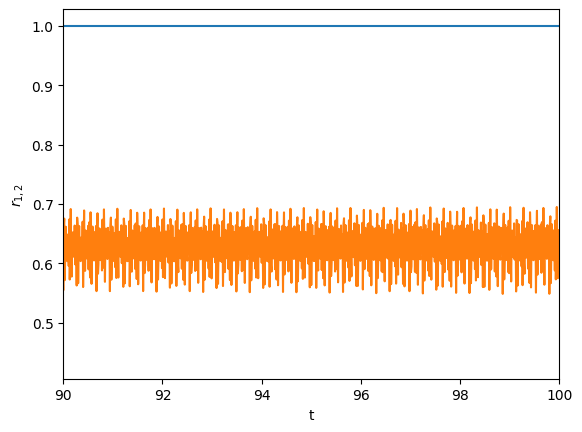

In [174]:
plt.figure()
plt.plot(t,r_I_1)
plt.plot(t,r_I_2)
plt.xlabel('t')
plt.ylabel(r'$r_{1,2}$')
plt.xlim(90,100)
print(min(r_last1,r_last2))

In [144]:
norm.ppf(x_,loc=-0.1,scale=std)

array([-9.36980546e+00, -8.73353836e+00, -8.34235992e+00, -8.05519595e+00,
       -7.82644997e+00, -7.63537375e+00, -7.47071192e+00, -7.32565111e+00,
       -7.19574294e+00, -7.07791737e+00, -6.96996350e+00, -6.87023448e+00,
       -6.77746961e+00, -6.69068156e+00, -6.60908219e+00, -6.53203200e+00,
       -6.45900469e+00, -6.38956175e+00, -6.32333383e+00, -6.26000681e+00,
       -6.19931126e+00, -6.14101422e+00, -6.08491291e+00, -6.03082968e+00,
       -5.97860795e+00, -5.92810904e+00, -5.87920946e+00, -5.83179879e+00,
       -5.78577788e+00, -5.74105734e+00, -5.69755627e+00, -5.65520127e+00,
       -5.61392547e+00, -5.57366781e+00, -5.53437235e+00, -5.49598773e+00,
       -5.45846668e+00, -5.42176558e+00, -5.38584410e+00, -5.35066485e+00,
       -5.31619314e+00, -5.28239670e+00, -5.24924544e+00, -5.21671130e+00,
       -5.18476803e+00, -5.15339105e+00, -5.12255733e+00, -5.09224521e+00,
       -5.06243436e+00, -5.03310561e+00, -5.00424090e+00, -4.97582319e+00,
       -4.94783637e+00, -

(array([ 3.,  6., 12., 19., 24., 24., 19., 12.,  6.,  3.]),
 array([-2.85374921e+00, -2.28299937e+00, -1.71224953e+00, -1.14149968e+00,
        -5.70749842e-01, -8.88178420e-16,  5.70749842e-01,  1.14149968e+00,
         1.71224953e+00,  2.28299937e+00,  2.85374921e+00]),
 <BarContainer object of 10 artists>)

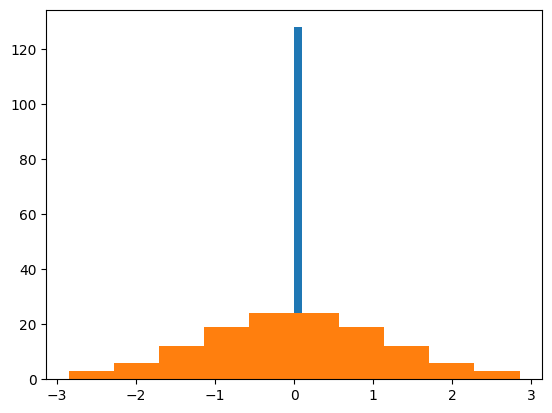

In [145]:
plt.hist(theta_init[:N1])
plt.hist(theta_init[N1:])

0.6253077962955423

In [ ]:
theta_init = np.zeros((N1+N2))


In [111]:
AnsP 

array(5.7319547)